<a href="https://colab.research.google.com/github/tonytarizzo/paddyRiceCompetition/blob/main/paddyCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install timm
#!pip install Pillow


try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import*
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:13<00:00, 81.1MB/s]


In [5]:
path


Path('paddy-disease-classification')

In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


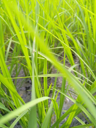

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *
from PIL import Image as PILImage


def f(o): return (o, PILImage.open(o).size)
sizes = parallel(f, files, n_workers=8)

incorrect_size_files = [f[0] for f in sizes if f[1] != (480, 640)]

def rotate_and_save(filepath):
    with PILImage.open(filepath) as img:
        rotated = img.rotate(90, expand=True)
        rotated.save(filepath)

parallel(rotate_and_save, incorrect_size_files, n_workers=8)

#pd.Series(sizes).value_counts()


(#4) [None,None,None,None]

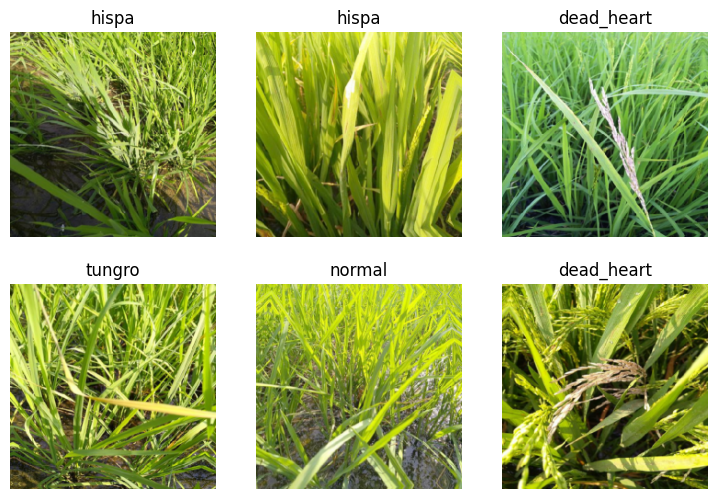

In [26]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))
#bs=16
dls.show_batch(max_n=6)

In [27]:
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate, path='.').to_fp16()
#resnet26d

SuggestedLRs(valley=0.009120108559727669, slide=0.0831763744354248)

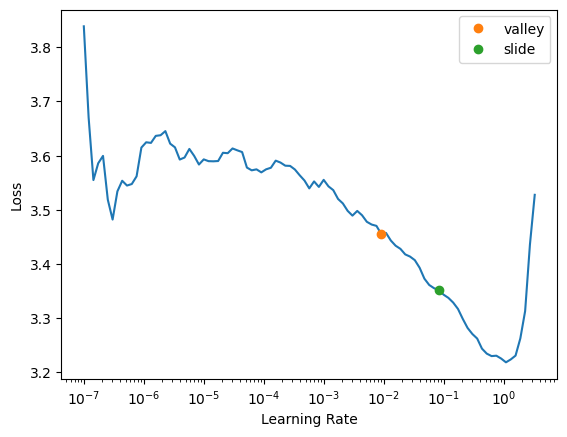

In [28]:
learn.lr_find(suggest_funcs=(valley, slide))

In [29]:
learn.fine_tune(9, 0.03)

epoch,train_loss,valid_loss,error_rate,time
0,2.162617,1.346882,0.460836,01:31


epoch,train_loss,valid_loss,error_rate,time
0,1.496727,1.157823,0.390678,01:34
1,1.341202,1.032005,0.354637,01:33
2,1.215013,0.963226,0.336857,01:34
3,1.131911,0.852256,0.290726,01:35
4,1.053493,0.791547,0.265738,01:35
5,0.992673,0.767440,0.256127,01:35
6,0.984738,0.752396,0.255646,01:38
7,0.944074,0.733369,0.248919,01:34
8,0.952326,0.734743,0.256127,01:36


In [30]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [31]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [32]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 7,  ..., 8, 7, 5])

In [33]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [34]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0            hispa
1           normal
2            hispa
3            blast
4            blast
           ...    
3464    dead_heart
3465        normal
3466        normal
3467         hispa
3468    dead_heart
Name: idxs, Length: 3469, dtype: object

In [35]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,downy_mildew
200007.jpg,dead_heart
200008.jpg,hispa
200009.jpg,hispa


In [37]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 67.1k/67.1k [00:03<00:00, 18.0kB/s]
